In [1]:
import os
import sys
import glob
import glob
import xesmf as xe
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
project_root = Path.cwd().parent  
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from src.utils.utils import data_split

# Get Static Parameters

In [2]:
static = xr.open_dataset('/bsuscratch/stanleyakor/uppercolorado/static_inputs/wrfout_d02_2000-04-08_00:00:00').isel(Time = 0)

lat = static.XLAT.values[:,0]
lon = static.XLONG.values[0,:]

# Evaluate Emulated SWE

In [3]:
start = '2015-10-06'
end = '2016-09-30'

wy_2016_true = data_split('2016','2016').sel(XTIME = slice(start, end)) # true swe: naoh-mp

wy_w016_pred = xr.open_dataset('../data/WRF_MODIS_STATIC_v2_PREDITICTION.nc') # convlstm emulated swe

corr_data= xr.corr(wy_2016_true['SNOW'], wy_w016_pred['SNOW'], dim='XTIME') # correlation between emulated and noah-mp swe

rmse =  np.sqrt(((wy_2016_true['SNOW'] - wy_w016_pred['SNOW']) ** 2).mean(dim = 'XTIME')) # rmse

noah_np_mean = wy_2016_true.mean(dim='XTIME')['SNOW']
convlstm_mean = wy_w016_pred.mean(dim='XTIME')['SNOW']

threshold = 10
rmse_masked = rmse.where(rmse >= threshold) # mask rmse values below 10 mm

/bsuhome/stanleyakor/miniconda3/envs/emulator_torch/lib/python3.10/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


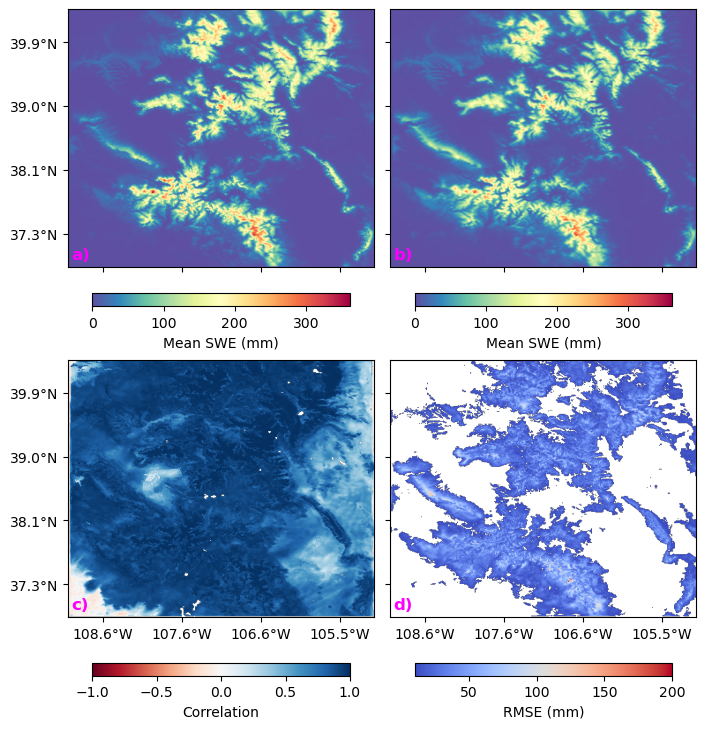

In [4]:

fig, axes = plt.subplots(2, 2, figsize=(7, 7.2), constrained_layout=True)

vmax = max(np.nanmax(ds.values) for ds in [noah_np_mean, convlstm_mean])
vmin = min(np.nanmin(ds.values) for ds in [noah_np_mean, convlstm_mean])
diff = 0.45
cmap1 = 'Spectral_r'  


datasets = [noah_np_mean, convlstm_mean , corr_data, rmse_masked]
titles = ['a)', 'b)', 'c)', 'd)']
cmaps = [cmap1, cmap1, 'RdBu', 'coolwarm']
vmins = [vmin, vmin, -1, threshold]
vmaxs = [vmax, vmax, 1, 200]
cbar_labels = ['Mean SWE (mm)', 'Mean SWE (mm)', 'Correlation', 'RMSE (mm)']


for ax, data, title, cmap, vmin, vmax, cbar_label in zip(axes.flat, datasets, titles, cmaps, vmins, vmaxs, cbar_labels):
    im = ax.imshow(data, extent=(lon.min(), lon.max(), lat.min(), lat.max()), 
                   cmap=cmap, vmin=vmin, vmax=vmax, origin='lower',alpha=1.)
    
    ax.set_aspect("auto")
    ax.text(0.01, 0.03, title, transform=ax.transAxes, fontsize=12, color='magenta', weight='bold')

   
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05, pad=0.08)
    cbar.set_label(cbar_label)

# Format ticks and labels
for i, ax in enumerate(axes.flat):
    ax.set_xticks(np.linspace(lon.min() + diff, lon.max() - diff, 4))
    ax.set_yticks(np.linspace(lat.min() + diff, lat.max() - diff, 4))

    lon_ticks = ax.get_xticks()
    lat_ticks = ax.get_yticks()
    
    lon_labels = [f'{abs(lon):.1f}°{"W" if lon < 0 else "E"}' for lon in lon_ticks]
    lat_labels = [f'{abs(lat):.1f}°{"S" if lat < 0 else "N"}' for lat in lat_ticks]
    
    ax.set_xticklabels(lon_labels)
    ax.set_yticklabels(lat_labels)

    
    if i % 2 == 1:
        ax.set_yticklabels([''] * len(ax.get_yticks()))

    if i <  2:
        ax.set_xticklabels([''] * len(ax.get_xticks()))
# plt.savefig('x.pdf')
plt.show()


In [5]:
convlstm_spatial_mean  = wy_w016_pred['SNOW'].mean(dim=('south_north', 'west_east'))
noah_np_spatial_mean = wy_2016_true['SNOW'].mean(dim=('south_north', 'west_east'))

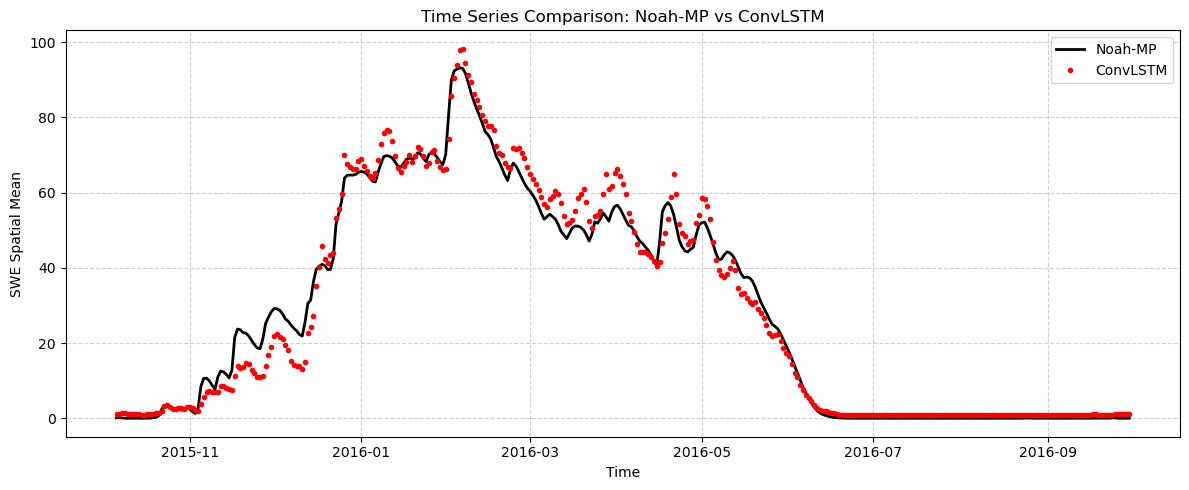

In [6]:
N = len(noah_np_spatial_mean)
time_index = pd.date_range(start="2015-10-06", periods=N, freq="D")  # adjust start date

plt.figure(figsize=(12, 5))


plt.plot(time_index, noah_np_spatial_mean, color="black", linewidth=2, label="Noah-MP")


plt.plot(time_index, convlstm_spatial_mean, "o", color="red", markersize=3, label="ConvLSTM")


plt.xlabel("Time")
plt.ylabel("SWE Spatial Mean")
plt.title("Time Series Comparison: Noah-MP vs ConvLSTM")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [7]:
hgt = static['HGT']
threshold =hgt.values.mean()


def temp_high(hgt,wy_w016_pred,wy_2016_true):
    pred,true = [],[]
    
    for time_step in wy_w016_pred.XTIME:
        # Select the data for the current time step
        pred_data = wy_w016_pred.sel(XTIME=time_step)
    
        true_data = wy_2016_true.sel(XTIME=time_step)
    
        pred.append(pred_data.where(hgt >= threshold, drop=True).mean(dim=('south_north', 'west_east')))
        true.append(true_data.where(hgt >= threshold, drop=True).mean(dim=('south_north', 'west_east')))


    return xr.DataArray(true, coords=[wy_w016_pred.XTIME], dims=['XTIME']), xr.DataArray(pred, coords=[wy_w016_pred.XTIME], dims=['XTIME'])


def temp_low(hgt,wy_w016_pred,wy_2016_true):
    pred,true = [],[]
    
    for time_step in wy_w016_pred.XTIME:
        # Select the data for the current time step
        pred_data = wy_w016_pred.sel(XTIME=time_step)
    
        true_data = wy_2016_true.sel(XTIME=time_step)
    
        pred.append(pred_data.where(hgt < threshold, drop=True).mean(dim=('south_north', 'west_east')))
        true.append(true_data.where(hgt < threshold, drop=True).mean(dim=('south_north', 'west_east')))


    return xr.DataArray(true, coords=[wy_w016_pred.XTIME], dims=['XTIME']), xr.DataArray(pred, coords=[wy_w016_pred.XTIME], dims=['XTIME'])


In [8]:
a,b = temp_high(hgt,wy_w016_pred['SNOW'],wy_2016_true['SNOW'])
c,d= temp_low(hgt,wy_w016_pred['SNOW'],wy_2016_true['SNOW'])

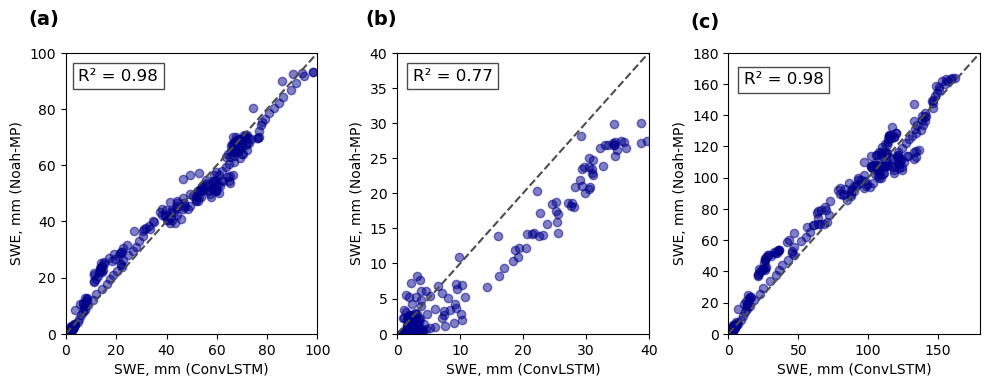

In [9]:



fig, ax = plt.subplots(1, 3, figsize=(10, 4.))

# Helper function to draw diagonal line and handle limit changes
def draw_diag_line(axis):
    diag_line, = axis.plot(axis.get_xlim(), axis.get_ylim(), ls="--", c=".3")

    def on_change(event_ax):
        diag_line.set_data(event_ax.get_xlim(), event_ax.get_ylim())

    axis.callbacks.connect('xlim_changed', on_change)
    axis.callbacks.connect('ylim_changed', on_change)


# Helper function to compute and add R² value
def add_r2_score(ax, x, y,xlim = 5,ylim = 90):
    r2 = r2_score(y, x)  # Compute R²
    ax.text(xlim, ylim, f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))  # Add R² text



subplot_labels = ['(a)', '(b)', '(c)']
for i, axis in enumerate(ax):

    if i == 1:
        axis.text(-5, 44, subplot_labels[i], fontsize=14, fontweight='bold')
    if i == 2:
        axis.text(-27, 196, subplot_labels[i], fontsize=14, fontweight='bold')  
    if i ==0:
        
        axis.text(-15, 110, subplot_labels[i], fontsize=14, fontweight='bold') 

    
# Plot for ax[0]
ax[0].scatter(convlstm_spatial_mean, noah_np_spatial_mean, alpha=0.5, color='darkblue')
ax[0].set_ylim([0, 100])
ax[0].set_xlim([0, 100])
ax[0].set_xlabel('SWE, mm (ConvLSTM)')
ax[0].set_ylabel('SWE, mm (Noah-MP)')
# ax[0].legend()
draw_diag_line(ax[0])
add_r2_score(ax[0], convlstm_spatial_mean, noah_np_spatial_mean)


# Plot for ax[1]
ax[1].scatter(d, c, alpha=0.5, color='darkblue')
ax[1].set_ylim([0, 40])
ax[1].set_xlim([0, 40])
ax[1].set_xlabel('SWE, mm (ConvLSTM)')
ax[1].set_ylabel('SWE, mm (Noah-MP)')
draw_diag_line(ax[1])
add_r2_score(ax[1], d, c,2.5, 36)

# Plot for ax[1]
ax[2].scatter(b, a, alpha=0.5, color='darkblue')
ax[2].set_ylim([0, 180])
ax[2].set_xlim([0, 180])
ax[2].set_xlabel('SWE, mm (ConvLSTM)')
ax[2].set_ylabel('SWE, mm (Noah-MP)')
draw_diag_line(ax[2])
add_r2_score(ax[2], b, a,11, 160)

plt.tight_layout()
plt.show()

# SNODAS COMPARISON

In [10]:
path = '/bsuscratch/stanleyakor/NOHRSC_SNODAS/download_data/download_data/nc/SWE*'

In [11]:
swe_files = sorted(glob.glob(os.path.join(path)))
d = xr.open_mfdataset(swe_files,  concat_dim = 'time',combine='nested', parallel = True)

In [12]:
def regrid_snodas(wrf_file, ds_snodas, var, multiple_time = True):
    if multiple_time:
        ds_snodas= ds_snodas.swap_dims({'time': 'XTIME'})
        ds_snodas['XTIME'] = ds_snodas['time']
        ds_snodas = ds_snodas.drop_vars('time')
    else:   
        ds_snodas = ds_snodas.sel(time = '2022-01-12T06:00:00')
        
    ds_snodas = ds_snodas[var]

    grid_template = xr.open_dataset(wrf_file)
    LAT = grid_template.variables['XLAT'][0].copy()
    LON =grid_template.variables['XLONG'][0].copy()
    #create target grid
    target_grid = xr.Dataset({'lat': LAT,'lon': LON})
    # Create xESMF regridder using the target grid
    regridder = xe.Regridder(ds_snodas, target_grid, 'bilinear')
    return regridder(ds_snodas)

In [13]:
regridded_snodas = regrid_snodas('/bsuscratch/stanleyakor/uppercolorado/static_inputs/wrfout_d02_2000-04-08_00:00:00', d,'SWE')
regridded_snodas = regridded_snodas.sel(XTIME = slice(start, end))

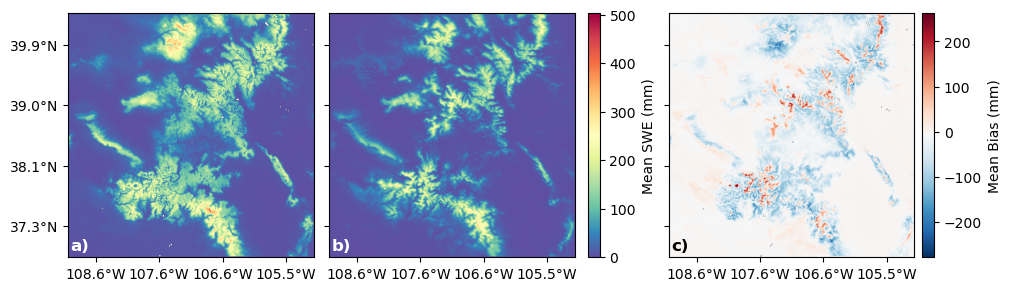

In [14]:

fig, axes = plt.subplots(1, 3, figsize=(10, 2.8), constrained_layout=True)


geog1 = regridded_snodas.mean(dim='XTIME')
geog2 = wy_w016_pred.mean(dim='XTIME')['SNOW']
mb = (wy_w016_pred['SNOW'].values - regridded_snodas).mean(dim='XTIME', skipna=True)

# Colormap and value range for SWE maps
vmax = max(np.nanmax(geog1.values), np.nanmax(geog2.values))
vmin = min(np.nanmin(geog1.values), np.nanmin(geog2.values))
cmap1 = 'Spectral_r'


im_list = []
for ax, data, label in zip(axes[:2], [geog1, geog2], ['a)', 'b)']):
    im = ax.imshow(data, extent=(lon.min(), lon.max(), lat.min(), lat.max()), 
                   cmap=cmap1, vmin=vmin, vmax=vmax, origin='lower')
    im_list.append(im)
    ax.set_aspect("auto")
    ax.text(0.01, 0.03, label, transform=ax.transAxes, fontsize=12, color='white', weight='bold')


cbar1 = fig.colorbar(im_list[0], ax=axes[:2], orientation='vertical', fraction=0.05, pad=0.02)
cbar1.set_label('Mean SWE (mm)')

# Plot RMSE map
im_rmse = axes[2].imshow(mb, extent=(lon.min(), lon.max(), lat.min(), lat.max()), 
                         cmap='RdBu_r',origin='lower')
axes[2].set_aspect("auto")
axes[2].text(0.01, 0.03, 'c)', transform=axes[2].transAxes, fontsize=12, color='black', weight='bold')

# Separate colorbar for RMSE
cbar2 = fig.colorbar(im_rmse, ax=axes[2], orientation='vertical', fraction=0.06, pad=0.02)
cbar2.set_label('Mean Bias (mm)')


diff = 0.45
for i, ax in enumerate(axes):
    ax.set_xticks(np.linspace(lon.min() + diff, lon.max() - diff, 4))
    ax.set_yticks(np.linspace(lat.min() + diff, lat.max() - diff, 4))

    lon_labels = [f'{abs(l):.1f}°{"W" if l < 0 else "E"}' for l in ax.get_xticks()]
    lat_labels = [f'{abs(l):.1f}°{"S" if l < 0 else "N"}' for l in ax.get_yticks()]

    ax.set_xticklabels(lon_labels)
    ax.set_yticklabels(lat_labels if i == 0 else [''] * len(lat_labels))
plt.show()
